In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 58.9 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 448 kB 47.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import io
import pandas as pd
import numpy as np
import csv
from google.colab import files
import pandas as pd # to use dataframes
from math import log # for IDF calculation
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import konlpy
import re
from konlpy.tag import Okt

##File uploading

There are two files
1. review file
2. stopword file

In [ ]:
f =files.upload()

Saving stopword.csv to stopword.csv
Saving total_review.csv to total_review.csv


In [ ]:
#List stopwords.
sw = pd.read_csv('./stopword.csv')
sw = sw.transpose()
sw.reset_index(drop=False, inplace=True)
stop_word = np.array(sw.iloc[0].tolist()) #stop_word : stopword list

#Create a review data frame.
df=pd.read_csv('./total_review.csv')
df['menu'] = df['menu'].str.strip() # review dataframe

##Data Preprocessing

In [ ]:
df = df.drop('price', axis =1)
df = df.dropna(axis=0)
df

,category,restaurant,menu,review
0,chicken,bbq,황금올리브치킨,"기본 구성은 치킨과 더불어서 치킨무, 그리고 bbq 시크릿 양념치킨소스, 비비소스(..."
1,chicken,bbq,황금올리브치킨,\n\n개인적으로 제일 맛있다고 생각하는 후라이드치킨은\n\n비비큐 황금올리브치킨이...
2,chicken,bbq,황금올리브치킨,닭다리를 들어보았다. 바로 옆에 닭다리가 하나 더 보이네. 사진으로 보기만 해도 바...
3,chicken,bbq,황금올리브치킨,\n\n \n\n일단 튀김상태 정말 바삭해요. 만져보면 바삭바삭한 느낌이 들 정도로...
4,chicken,bbq,황금올리브치킨,위가 바로 황금올리브치킨이에요. 정말로 황금빛이 나요. 교촌치킨이나 여타 치킨과는 ...
...,...,...,...,...
3955,snack bar,타코야킹,갈릭치즈 타코야끼,맛있어요~ 가끔 시켜먹습니다
3956,snack bar,타코야킹,갈릭치즈 타코야끼,진짜 맛있게먹었어요 저한텐 소스가 좀 자극적이라 조금만 달라했더니 제 입맛엔 평소보...
3957,snack bar,타코야킹,갈릭치즈 타코야끼,갈릭 파우더가 맛있어요
3958,snack bar,타코야킹,갈릭치즈 타코야끼,"맛있어요, 야식으로 쵝오!!!"


In [ ]:
final_data = pd.DataFrame({'store':df['restaurant'], 'menu':df['menu']})
final_data

,store,menu
0,bbq,황금올리브치킨
1,bbq,황금올리브치킨
2,bbq,황금올리브치킨
3,bbq,황금올리브치킨
4,bbq,황금올리브치킨
...,...,...
3955,타코야킹,갈릭치즈 타코야끼
3956,타코야킹,갈릭치즈 타코야끼
3957,타코야킹,갈릭치즈 타코야끼
3958,타코야킹,갈릭치즈 타코야끼


Collect reviews according to the same menu.

In [ ]:
data = pd.DataFrame(df.groupby('menu')['review'])
data.columns=['menu','review']
for i in range(len(data)):
  list = data['review'][i]
  n_review = ','.join(str(e) for e in list)
  data['review'][i] = n_review
menu_review = data
menu_review #Dataframe with only menus and reviews

,menu,review
0,85국밥,날씨도 춥고 해서 간만에 시켜 먹었는데 정말 맛있어요!! 근데 양파 장아찌는 별루....
1,T-REX버거,"번스보다 큰 '통다리살'치킨패티에 부드러운 크림어니언 소스를 더한 가성비 제품,양상..."
2,doubleX2버거,"순비프패티 2장, 치즈 2장을 활용한 맛이 조화로운 정통 아메리칸 버거,수제버거맛이..."
3,갈릭족,맛있게 잘 먹었습니다. 오랜만에 갈릭족을 시켰는데 맛은 있지만 양은 조금 적네요. ...
4,갈릭치즈 타코야끼,"갈릭치즈가 제일 맛있어요!,맛있는데 조금 눌러붙어서 왔어요,멀어서 조금 식었지만 맛..."
...,...,...
151,핫크리스피버거,토마토와 레타스등의 야채와 하바네로香이 가미된 가슴살로 만든 매콤한 Premium ...
152,해물 순두부찌개,"잘먹엇습니다~~ 사장님,양이..3인분짜리를 시켰는데 5인분은 될거같은 양에다가 쌈도..."
153,향채족,"원래 매장에서 먹었는데 이사와서 배달시켜먹었네요. !,앞다리만 시켜 먹다가 시간이 ..."
154,홍어삼합,배달오신분도 친절하시고 맛있게 잘 먹었습니다.


In [ ]:
okt = konlpy.tag.Okt()

#sub_specieal : Function to remove everything except Korean, numbers, and English
def sub_special(text):
  pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # Remove E-mail
  text = re.sub(pattern=pattern, repl='', string=text)

  pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # Remove URL
  text = re.sub(pattern=pattern, repl='', string=text)

  pattern = '([a-heh-ㅣ]+)' # Remove Korean consonants and vowels
  text = re.sub(pattern=pattern, repl='', string=text)

  pattern = '<[^>]*>' # Remove HTML tags
  text = re.sub(pattern=pattern, repl='', string=text)

  pattern = '[^\w\s]' # Remove special characters
  text = re.sub(pattern=pattern, repl='', string=text)

  text = re.sub('[^0-9a-zA-Zㄱ-ㅎ가-힣]', ' ', text)

  return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]','',text)

STOP_WORDS = ['음료','소스','인세트','인','mL','선택','추가','변경','pcs','g','선택','사이드','M','L','R','세트','순살','하다',',','\n','이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def morph_and_stopword(s):
  tok = ""
  #morpheme analysis
  tmp = okt.morphs(s, stem=True)

  #handling stopwords
  for token in tmp:
    if token not in STOP_WORDS:
      tok = tok+token
  return tok

In [ ]:
'''for j in range(len(menu_review['menu'])):
  before = menu_review.loc[j]['menu']
  #sub_specieal Remove everything except Korean, numbers, and English
  after = sub_special(before)
  menu_review.loc[j]['menu'] = re.sub(r'[0-9]+', '', after)'''

for i in range(len(menu_review['review'])):
  before = menu_review.loc[i]['review']
  #sub_specieal : Function to remove everything except Korean, numbers, and English  after = sub_special(before)
  after = sub_special(before)
  menu_review.loc[i]['review'] = re.sub(r'[0-9]+', '', after)

In [ ]:
menu_review

,menu,review
0,85국밥,날씨도 춥고 해서 간만에 시켜 먹었는데 정말 맛있어요 근데 양파 장아찌는 별루 다른...
1,T-REX버거,번스보다 큰 통다리살치킨패티에 부드러운 크림어니언 소스를 더한 가성비 제품양상추와 ...
2,doubleX2버거,순비프패티 장 치즈 장을 활용한 맛이 조화로운 정통 아메리칸 버거수제버거맛이랑 비슷...
3,갈릭족,맛있게 잘 먹었습니다 오랜만에 갈릭족을 시켰는데 맛은 있지만 양은 조금 적네요 앞으...
4,갈릭치즈 타코야끼,갈릭치즈가 제일 맛있어요맛있는데 조금 눌러붙어서 왔어요멀어서 조금 식었지만 맛있어요...
...,...,...
151,핫크리스피버거,토마토와 레타스등의 야채와 하바네로 이 가미된 가슴살로 만든 매콤한 P 치킨버거치킨...
152,해물 순두부찌개,잘먹엇습니다 사장님양이인분짜리를 시켰는데 인분은 될거같은 양에다가 쌈도 인수맞게 소...
153,향채족,원래 매장에서 먹었는데 이사와서 배달시켜먹었네요 앞다리만 시켜 먹다가 시간이 늦어서...
154,홍어삼합,배달오신분도 친절하시고 맛있게 잘 먹었습니다


In [ ]:
menu_index = menu_review['menu'].values.tolist() #menu name list

In [ ]:
docs= menu_review['review'].values.tolist() #A list of all reviews

##Tokenization - Stemming(형태소분석)

To analyze text, you must first divide the text into tokens, which are the units of analysis. This is called tokenization.
In Korean, there are no spaces between nouns and verbs, and various endings are added to verbs to complicate tokenization. Korean is tokenized by morphological analysis. A morpheme is the smallest unit that has meaning.
For example, in the case of "eaten", it is composed of three morphemes: the verb 'muk' + the first ending ending 'had' + the ending ending 'da'.

In [ ]:
#get_pos : Function to analyze morphemes
def get_pos(text):
  okt_pos = Okt().pos(text, norm=True, stem=True)
  okt_filtering = [x for x, y in okt_pos if y in ['Noun', 'Adjective', 'Verb']]
  return okt_filtering

##TF-IDF matrix
TF-IDF is a method of calculating the weight of words in a document by finding “words that do not appear in other documents but appear frequently in a specific document”.

* TF: the number of occurrences of a specific word t in a specific document d
* DF: the number of documents in which a particular word t appears
* IDF : A number that is inversely proportional to DF (results vary depending on whether idf-smoothing or not)
* TF-IDF: Multiplied by TF and IDF

##Why use TF-IDF?
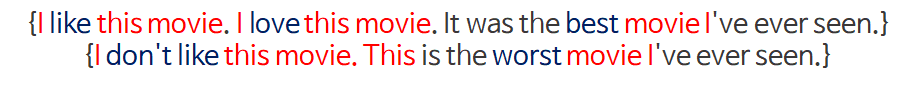

The "Feature Extraction" process is performed using the content of Item as a vector.
It captures important words that appear a lot based on frequency. This method is called a Counter Vectorizer.

However, since Counter Vectorizer only calculates simple frequencies, there is a limitation in that words that appear a lot in sentences are high, although they have no meaning like investigations and articles. The TF-IDF technique is to give a penalty to these words (I, this, movie, etc.) and to catch only the appropriately important words.



Check from the Counter Vectorizer that composes the TF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer=get_pos)

# Transform the sentence into a Counter Vectorizer form
countvect = vect.fit_transform(docs)
countvect

<156x3835 sparse matrix of type '<class 'numpy.int64'>'
	with 16777 stored elements in Compressed Sparse Row format>

156x3835 means that 3835 words on 156 menus.




In [ ]:
# Find out how each menu is vectorized through toarray()
# But I don't know what each index and column means
countvect.toarray()

array([[0, 1, 6, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 1, 0, 0]])

Values 0, 1, 2 : Assigned according to the number of occurrences of a word in the document.

To know what each index and column means, we need to extract the vocabulary_ information from the object and look at the information.

In [ ]:
vect.vocabulary_

{'날씨': 531,
 '추다': 3306,
 '하다': 3636,
 '간만': 51,
 '시키다': 2019,
 '먹다': 1220,
 '정말': 2905,
 '맛있다': 1157,
 '양파': 2236,
 '장아찌': 2814,
 '별루': 1519,
 '다르다': 670,
 '완전': 2445,
 '만족하다': 1116,
 '공기': 255,
 '배': 1458,
 '터지다': 3461,
 '같다': 104,
 '넘다': 584,
 '깔끗': 433,
 '자다': 2756,
 '예상': 2374,
 '시간': 1994,
 '늦다': 653,
 '오다': 2387,
 '따뜻하다': 921,
 '곳': 250,
 '넣다': 591,
 '보관': 1527,
 '중이': 3031,
 '셨': 1881,
 '감동': 71,
 '아기': 2121,
 '있다': 2746,
 '밖': 1420,
 '어서': 2254,
 '화상': 3772,
 '십': 2077,
 '것': 165,
 '사먹다': 1753,
 '배달': 1461,
 '되어다': 856,
 '좋다': 2983,
 '고기': 209,
 '양도': 2228,
 '푸다': 3596,
 '짐': 3098,
 '부드럽다': 1587,
 '추천': 3313,
 '해': 3686,
 '처음': 3241,
 '주문': 3000,
 '구성': 295,
 '맛': 1139,
 '뭐': 1352,
 '하나': 3633,
 '빠지다': 1708,
 '나다': 504,
 '예전': 2378,
 '때': 940,
 '더': 789,
 '좀더': 2975,
 '깊다': 424,
 '수육': 1934,
 '김치': 421,
 '서비스': 1839,
 '주신': 3004,
 '음료수': 2604,
 '늘': 648,
 '존맛': 2965,
 '입다': 2736,
 '부모님': 1594,
 '단골': 698,
 '들다': 896,
 '국밥집': 310,
 '제': 2922,
 '여기': 2320,
 '드리다': 888,
 '앞': 219

It has a value in the form of a dictionary, where each value means the position of the column, and the key means the word in the corresponding column.

For example, ''오래오래': 2376' means the 2376th column.

To make it look good, we will sort by value.

In [ ]:
sorted(vect.vocabulary_)[:10]

['가가', '가게', '가격', '가기', '가까이', '가깝다', '가끔', '가능하다', '가다', '가다랑어포']

In [ ]:
import pandas as pd
#Giving column and row indexes
countvect_df = pd.DataFrame(countvect.toarray(), columns = sorted(vect.vocabulary_))
countvect_df.index = menu_index
countvect_df

,가가,가게,가격,가기,가까이,가깝다,가끔,가능하다,가다,가다랑어포,가득,가득하다,가라,가라앉다,가려지다,가루,가르치다,가리다,가면,가모,가물,가물다,가미,가버리다,가볍다,가보다,가성,가스,가슴,가쓰오부시,가안,가요,가용,가장,가장자리,가젤,가져가다,가져다주다,가족,가지,...,후기,후다닥,후라이드,후루룩,후문,후식,후추,후회,후회되다,훈늉안,훈제,훌륭,훌륭하다,훌쩍,훠,훠궈,훨,휘하다,휴무,흐뜨러지,흐르다,흐리다,흐물하,흐물흐물,흐트러지,흐트러진,흑임자,흔하다,흘러내리다,흘리다,흠,흠잡다,흡수,흡입,흥건,희다,힘내다,힘드다,힘들다,힜
85국밥,0,1,6,0,0,0,1,0,5,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,3,0,0,0,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,4,0
T-REX버거,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
doubleX2버거,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
갈릭족,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
갈릭치즈 타코야끼,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
핫크리스피버거,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
해물 순두부찌개,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
향채족,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
홍어삼합,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Calculate the similarity of each vector through the above data frame
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(countvect_df, countvect_df)
#This allows us to know which menus are similar.

array([[1.        , 0.03780291, 0.17345162, ..., 0.4846235 , 0.59053673,
        0.46047587],
       [0.03780291, 1.        , 0.30759929, ..., 0.        , 0.        ,
        0.22976242],
       [0.17345162, 0.30759929, 1.        , ..., 0.02687154, 0.        ,
        0.29797863],
       ...,
       [0.4846235 , 0.        , 0.02687154, ..., 1.        , 0.28097574,
        0.25288193],
       [0.59053673, 0.        , 0.        , ..., 0.28097574, 1.        ,
        0.19776079],
       [0.46047587, 0.22976242, 0.29797863, ..., 0.25288193, 0.19776079,
        1.        ]])

##Perform TF-IDF in the same way

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(tokenizer= get_pos) #tokenizer= get_pos : tokenize with morphemes
tfvect = vect.fit(docs)
tfidf_matrix = vect.fit_transform(menu_review['review'])

tfidv_df = pd.DataFrame(tfvect.transform(docs).toarray(), columns = sorted(vect.vocabulary_))
tfidv_df.index = menu_index
tfidv_df

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


,가가,가게,가격,가기,가까이,가깝다,가끔,가능하다,가다,가다랑어포,가득,가득하다,가라,가라앉다,가려지다,가루,가르치다,가리다,가면,가모,가물,가물다,가미,가버리다,가볍다,가보다,가성,가스,가슴,가쓰오부시,가안,가요,가용,가장,가장자리,가젤,가져가다,가져다주다,가족,가지,...,후기,후다닥,후라이드,후루룩,후문,후식,후추,후회,후회되다,훈늉안,훈제,훌륭,훌륭하다,훌쩍,훠,훠궈,훨,휘하다,휴무,흐뜨러지,흐르다,흐리다,흐물하,흐물흐물,흐트러지,흐트러진,흑임자,흔하다,흘러내리다,흘리다,흠,흠잡다,흡수,흡입,흥건,희다,힘내다,힘드다,힘들다,힜
85국밥,0.0,0.005008,0.021211,0.0,0.0,0.0,0.004635,0.000000,0.018952,0.0,0.0,0.005161,0.00696,0.0,0.0,0.0,0.00696,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.006434,0.011206,0.0,0.000000,0.0,0.0,0.005334,0.0,0.004183,0.0,0.0,0.0,0.0,0.004748,0.004261,...,0.004635,0.0,0.00000,0.0,0.0,0.0,0.0,0.022654,0.0,0.0,0.0,0.0,0.005334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.006060,0.0,0.0,0.005534,0.0,0.0,0.0,0.000000,0.018991,0.0
T-REX버거,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.104349,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
doubleX2버거,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
갈릭족,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.163853,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
갈릭치즈 타코야끼,0.0,0.000000,0.000000,0.0,0.0,0.0,0.135452,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
핫크리스피버거,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.115532,0.0,0.0,0.000000,0.000000,0.0,0.207255,0.0,0.0,0.000000,0.0,0.075109,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
해물 순두부찌개,0.0,0.028861,0.020373,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.043052,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.024558,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.034926,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
향채족,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(tfidv_df, tfidv_df)

array([[1.        , 0.02262221, 0.08201492, ..., 0.25010643, 0.29703948,
        0.25961176],
       [0.02262221, 1.        , 0.24946857, ..., 0.        , 0.        ,
        0.17690417],
       [0.08201492, 0.24946857, 1.        , ..., 0.01093852, 0.        ,
        0.10917439],
       ...,
       [0.25010643, 0.        , 0.01093852, ..., 1.        , 0.09645434,
        0.0903854 ],
       [0.29703948, 0.        , 0.        , ..., 0.09645434, 1.        ,
        0.07251557],
       [0.25961176, 0.17690417, 0.10917439, ..., 0.0903854 , 0.07251557,
        1.        ]])



*   Both TF-IDF and CounterVectorizer have the characteristic of creating a vector with all the words appearing in the content.

* So, as the content increases and the total number of words increases, the dimension of the vector will grow and the matrix will become unmanageable.
* To prevent this problem, there is a `max_features` parameter that tells you to use only the n most frequent words.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(tokenizer= get_pos, max_features=10) #set max_features is 10.
tfvect = vect.fit(docs)
tfidv_df = pd.DataFrame(tfvect.transform(docs).toarray(), columns = sorted(vect.vocabulary_))
tfidv_df.index = menu_index
tfidv_df

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


,많다,맛,맛있다,먹다,배달,시키다,있다,자다,좋다,하다
85국밥,0.207110,0.183602,0.522743,0.651255,0.238513,0.234188,0.070426,0.201797,0.165197,0.203218
T-REX버거,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doubleX2버거,0.000000,0.835374,0.000000,0.000000,0.000000,0.000000,0.375028,0.000000,0.201285,0.347836
갈릭족,0.000000,0.304940,0.469787,0.489222,0.252380,0.420927,0.171122,0.378252,0.183689,0.000000
갈릭치즈 타코야끼,0.000000,0.171180,0.879059,0.366171,0.141675,0.118145,0.000000,0.106167,0.103115,0.089096
...,...,...,...,...,...,...,...,...,...,...
핫크리스피버거,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
해물 순두부찌개,0.165099,0.516886,0.353915,0.532360,0.380262,0.237830,0.042972,0.213718,0.092255,0.199281
향채족,0.000000,0.000000,0.140197,0.583989,0.225951,0.753696,0.000000,0.000000,0.000000,0.142095
홍어삼합,0.000000,0.000000,0.403549,0.420244,0.650387,0.000000,0.000000,0.487380,0.000000,0.000000


In [ ]:
# Stopwords: Remove non-significant word tokens
#(idf has a similar role, but idf only gives some penalty, but removes stopwords altogether.)
tfidf = TfidfVectorizer(analyzer = 'word')
# Perform tf-idf for review
#TF is, after all, 'the more it appears, the more important it is.' It assumes that
#IDF rearranging, total number of documents / number of documents containing t - special word
tfidf_matrix = tfidf.fit_transform(menu_review['review'])
print(tfidf_matrix.shape)
print(sorted(tfidf.vocabulary_.items()))

(156, 14554)
[('bbc가', 0), ('bbq', 1), ('bbq는', 2), ('bbq를', 3), ('bbq의', 4), ('bhc', 5), ('bhc는', 6), ('bhc의', 7), ('bhc치킨', 8), ('bhc치킨메뉴', 9), ('bhc치킨은', 10), ('jmt', 11), ('jmt리뷰이벤트', 12), ('jmt역시최고입니당', 13), ('jmt타코야키', 14), ('l를', 15), ('가게', 16), ('가게가', 17), ('가게가서', 18), ('가게에', 19), ('가게에서', 20), ('가게에요', 21), ('가게와는', 22), ('가격', 23), ('가격과', 24), ('가격대비', 25), ('가격대비최고에요무난하게', 26), ('가격대에', 27), ('가격대원에', 28), ('가격도', 29), ('가격에', 30), ('가격은', 31), ('가격이', 32), ('가격이라니요', 33), ('가격인상', 34), ('가기도', 35), ('가까운', 36), ('가까워', 37), ('가까워서', 38), ('가까워요', 39), ('가까웠다', 40), ('가까웠지만', 41), ('가까이', 42), ('가깝긴하지만', 43), ('가끔', 44), ('가끔만', 45), ('가끔씩', 46), ('가끔이지만', 47), ('가네요든든하네요', 48), ('가는데', 49), ('가능하구요', 50), ('가능하다', 51), ('가능하다는', 52), ('가능한', 53), ('가능한건가요', 54), ('가능한것이', 55), ('가능할듯용양이', 56), ('가능할듯자주시켜먹는데', 57), ('가능합니다', 58), ('가능해서', 59), ('가다랑어포가', 60), ('가달라고', 61), ('가더라구요', 62), ('가득', 63), ('가득가득', 64), ('가득가득합니다', 65), ('가득인데다가', 66), ('가득하고', 67), ('가득한', 68

In [ ]:
#Measure the similarity through the cosine_similarity function
from sklearn.metrics.pairwise import cosine_similarity
cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(cosine_matrix.shape)
np.round(cosine_matrix, 4)

(156, 156)


array([[1.    , 0.0136, 0.0117, ..., 0.0587, 0.0923, 0.0936],
       [0.0136, 1.    , 0.025 , ..., 0.    , 0.    , 0.0161],
       [0.0117, 0.025 , 1.    , ..., 0.    , 0.    , 0.022 ],
       ...,
       [0.0587, 0.    , 0.    , ..., 1.    , 0.    , 0.0058],
       [0.0923, 0.    , 0.    , ..., 0.    , 1.    , 0.0029],
       [0.0936, 0.0161, 0.022 , ..., 0.0058, 0.0029, 1.    ]])

By taking a similarity matrix, the similarity was calculated for all menus.

However, it is not possible to know which food the corresponding index is.

##Create a dictionary to map menu names and ids.

In [ ]:
# Create a dictionary to map menu names and ids.
menuid= {}
for i, c in enumerate(menu_review['menu']): menuid[i] = c

# Create a dictionary to map ids to menu names.
idmenu = {}
for i, c in menuid.items(): idmenu[c] = i

In [ ]:
idmenu

{'85국밥': 0,
 'T-REX버거': 1,
 'doubleX2버거': 2,
 '갈릭족': 3,
 '갈릭치즈 타코야끼': 4,
 '감바스와 호밀빵': 5,
 '고기 순두부찌개': 6,
 '고스트페파로니 피자': 7,
 '골드킹': 8,
 '김치 베이컨 필라프 1인분': 9,
 '김치찌개': 10,
 '김치찌개&대패삼겹구이': 11,
 '김치찌개&양념게장': 12,
 '김치찌개&제육볶음': 13,
 '까르보나라누들떡볶이': 14,
 '까만찜닭': 15,
 '꿔바로우': 16,
 '날치알치즈 타코야끼': 17,
 '내장국밥': 18,
 '냉채족': 19,
 '단짠윙봉': 20,
 '더블바베큐 피자': 21,
 '더블포크쉬림프 콘치즈': 22,
 '더블포크쉬림프 피자': 23,
 '데리야끼족': 24,
 '돼지고기 김치찌개': 25,
 '떡갈비매콤크림파스타': 26,
 '레드마요치킨': 27,
 '로제누들떡볶이': 28,
 '로제떡볶이': 29,
 '로제분모자떡볶이': 30,
 '로제찜닭': 31,
 '리아미라클버거': 32,
 '마라상궈': 33,
 '마라탕': 34,
 '마왕치킨': 35,
 '맛초킹': 36,
 '매운삼겹살 덮밥＋된장찌개': 37,
 '매콤양념반반족': 38,
 '매콤크림 리조또': 39,
 '매콤크림 파스타': 40,
 '명란마요 타코야끼': 41,
 '명란치즈 타코야끼': 42,
 '명란치즈 타코야키': 43,
 '모짜렐라인더버거-베이컨': 44,
 '묵은지찜닭': 45,
 '물냉면': 46,
 '반올림고구마 골드 피자': 47,
 '반올림고구마 피자': 48,
 '베이컨 까르보나라 파스타': 49,
 '베이컨 로제 파스타': 50,
 '베이컨 토마토파스타': 51,
 '베이컨버섯 크림 리조또': 52,
 '베이컨쉬림프 치즈링 피자': 53,
 '베이컨쉬림프 피자': 54,
 '베이컨체다 피자': 55,
 '베이컨필라프': 56,
 '부채살스테이크＋구운야채': 57,
 '불고기 피자': 58,
 '불고기버거': 59,
 '불곱창 덮밥＋된

The top 10 menus are recommended through the similarity function created in this way.

First, extract the index of the desired menu '85 Gukbap' from the dictionary of idmenu.
In this case, idx will be 0. With this idx value, we now extract the menu with idx 0 from the cosine_matrix, the similarity value and index.

##For example, 10 top menu recommendations similar to 85국밥

In [ ]:
# Extract id of specific menu
idx = idmenu['85국밥']
sim_scores = [(i, c) for i, c in enumerate(cosine_matrix[idx]) if i != idx] # Extract similarity and index of foods excluding themselves
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True) # Sort by similarity # Extract the top 10 indexes and similarities
# convert index to menu name
sim_scores = [(menuid[i], score) for i, score in sim_scores[0:10]]
sim_scores

[('불향쭈꾸미볶음', 0.46219423919197483),
 ('돼지고기 김치찌개', 0.423297458360311),
 ('장모왕족(뒷다리)', 0.39898926506283566),
 ('연어사시미', 0.39552445236496014),
 ('섞어국밥', 0.3934794203579125),
 ('장모왕족(앞다리)', 0.37989780314803046),
 ('얼큰국밥', 0.3706452475255758),
 ('불스치즈떡볶이', 0.35589672594300786),
 ('오리지널타코야끼', 0.34608621323832034),
 ('김치찌개', 0.3439325994433438)]

In [ ]:
#Provide menu list
print(menu_index)
print('Among the food candidates, Enter the name of your favorite food: ')
# Enter the name of your favorite food
# If you enter it incorrectly, ask for it again
while True:
  i_like = str(input("I like "))
  if i_like in menu_index:
    break
  else :
    print('Please enter the food name correctly.')

#disliked food menu
dislike_list = []
print('Among the food candidates, Enter dislike food names:')
print("Enter one menu at a time. When you're done, Enter 'f'.")
while True:
  dislike = str(input("I don't like "))
  if dislike == 'f':
    break
  elif dislike not in menu_index:
    print('Please enter the food name correctly.')
  else:
    dislike_list.append(idmenu[dislike]) #Add id of disliked food
    dis_idx = idmenu[dislike] #Add the ids of the top 3 foods similar to the disliked food

    sim_scores = [(i, c) for i, c in enumerate(cosine_matrix[dis_idx]) if i != dis_idx ]
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:2] # Extract only the top 2 menu items (index, score) similar to the food you dislike
    for i in range(len(sim_scores)):
      dislike_list.append(sim_scores[i][0]) #sim_scores[i][0] Extract the idx of the menu to dislike or similar, and add it to dislike_list


# Enter the menu you do not want to eat because you have recently eaten
ideaten_list = []
print('Among the food candidates, Enter food names that you have recently eaten: ')
print("Enter one menu at a time. When you're done, Enter 'f'.")
while True:
  ideaten = str(input("I have recently eaten "))
  if ideaten == 'f':
    break
  elif ideaten not in menu_index:
    print('Please enter the food name correctly.')
  else:
    ideaten_list.append(idmenu[ideaten])

#Number of menus to be recommended
while True:
  n = input('How many menus would you like to recommend? :')
  if int(n) >= 50 :
    print('Too many! Enter less.')
  elif type(n) != 'int':
    print('Please enter the integer correctly.')
  n = int(n)
  break

sim_scores = [(i, c) for i, c in enumerate(cosine_matrix[idx]) if i != idx ]
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
sim_scores = [(menuid[i], score) for i, score in sim_scores if i not in ideaten_list and i not in dislike_list]

sim = [] #similarity
for j in range(40):
  sim.append(sim_scores[j][1])
new_rating=[] #guessing the user's rating
for j in range(n):
  new_rating.append(5*(sim_scores[j][1] - min(sim))/(max(sim)-min(sim)))

recom = [] #add name of store
for j in range(n):
  food = sim_scores[j][0]
  my_menu = final_data.index[final_data['menu'] == food][0]
  store = final_data['store'][my_menu]
  recom.append((store,)+ sim_scores[j])
final_recom = [] #add new_rating
for i in range(len(recom)):
  final_recom.append([(recom[i][0]), (recom[i][1]), new_rating[i].round(1)])
final_recom[:n]

['85국밥', 'T-REX버거', 'doubleX2버거', '갈릭족', '갈릭치즈 타코야끼', '감바스와 호밀빵', '고기 순두부찌개', '고스트페파로니 피자', '골드킹', '김치 베이컨 필라프 1인분', '김치찌개', '김치찌개&대패삼겹구이', '김치찌개&양념게장', '김치찌개&제육볶음', '까르보나라누들떡볶이', '까만찜닭', '꿔바로우', '날치알치즈 타코야끼', '내장국밥', '냉채족', '단짠윙봉', '더블바베큐 피자', '더블포크쉬림프 콘치즈', '더블포크쉬림프 피자', '데리야끼족', '돼지고기 김치찌개', '떡갈비매콤크림파스타', '레드마요치킨', '로제누들떡볶이', '로제떡볶이', '로제분모자떡볶이', '로제찜닭', '리아미라클버거', '마라상궈', '마라탕', '마왕치킨', '맛초킹', '매운삼겹살 덮밥＋된장찌개', '매콤양념반반족', '매콤크림 리조또', '매콤크림 파스타', '명란마요 타코야끼', '명란치즈 타코야끼', '명란치즈 타코야키', '모짜렐라인더버거-베이컨', '묵은지찜닭', '물냉면', '반올림고구마 골드 피자', '반올림고구마 피자', '베이컨 까르보나라 파스타', '베이컨 로제 파스타', '베이컨 토마토파스타', '베이컨버섯 크림 리조또', '베이컨쉬림프 치즈링 피자', '베이컨쉬림프 피자', '베이컨체다 피자', '베이컨필라프', '부채살스테이크＋구운야채', '불고기 피자', '불고기버거', '불곱창 덮밥＋된장찌개', '불벅 치즈링 피자', '불벅 피자', '불스무뼈닭발', '불스짜장떡볶이', '불스치즈꿀고마떡볶이', '불스치즈떡볶이', '불스치즈분모자떡볶이', '불스치즈우삼겹떡볶이', '불스치즈차돌떡볶이', '불스치즈페퍼로니폭탄떡볶이', '불향쭈꾸미볶음', '붉은대게장 비빔밥', '블랙오징어버거', '비빔냉면', '빨간찜닭', '뿌링클', '사각새우더블버거', '삼겹구이비빔밥＋된장찌개', '삼겹국밥', '새싹육회비빔밥＋된장찌개', '새우버거', '새우필라프', '섞어국밥', '수육백반', '수육보쌈', '순대국밥',

[['신천쭈꾸미문수점', '불향쭈꾸미볶음', 5.0],
 ['올바른김치찌개&양념게장', '돼지고기 김치찌개', 4.5],
 ['장모족발', '장모왕족(뒷다리)', 4.1],
 ['생연어전문점청연', '연어사시미', 4.1],
 ['85국밥&냉면', '섞어국밥', 4.0],
 ['장모족발', '장모왕족(앞다리)', 3.9],
 ['85국밥&냉면', '얼큰국밥', 3.7],
 ['불스떡볶이', '불스치즈떡볶이', 3.5],
 ['타코야킹', '오리지널타코야끼', 3.4],
 ['올바른김치찌개&양념게장', '김치찌개', 3.3]]

## Accuracy Test

In [ ]:
survey_data=pd.read_excel('만족데이터.xlsx')

In [ ]:
survey_data

,User_Id,Expected_rating,Actual_rating,Recommendation_satisfying_score
0,1,3.7,5.1,4.7
1,2,3.6,4.0,5.0
2,3,3.9,3.5,4.0
3,4,4.1,4.4,4.4
4,5,4.4,3.0,3.5
5,6,3.5,4.0,5.0
6,7,3.6,5.0,5.0
7,8,3.4,2.8,3.1
8,9,4.6,4.5,4.5
9,10,3.5,4.7,3.8


In [ ]:
survey_data['error'] = (survey_data['Expected_rating'] - survey_data['Actual_rating'])**2
survey_data

,User_Id,Expected_rating,Actual_rating,Recommendation_satisfying_score,error
0,1,3.7,5.1,4.7,1.96
1,2,3.6,4.0,5.0,0.16
2,3,3.9,3.5,4.0,0.16
3,4,4.1,4.4,4.4,0.09
4,5,4.4,3.0,3.5,1.96
5,6,3.5,4.0,5.0,0.25
6,7,3.6,5.0,5.0,1.96
7,8,3.4,2.8,3.1,0.36
8,9,4.6,4.5,4.5,0.01
9,10,3.5,4.7,3.8,1.44


In [ ]:
Total_error = np.mean(survey_data['error'])
Total_error

1.114

In [ ]:
Satisfying_score = np.mean(survey_data['Recommendation_satisfying_score'])
Satisfying_score

3.9699999999999998